# Бизнес анализ предсказанных данных 

## Импорт всех нужных библиотек и файлов

In [184]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [185]:
test_df = pd.read_parquet('test_df_peds.pqt')
train_df = pd.read_parquet('train_df_postprocess.pqt')

In [186]:
cluster_weights = pd.read_excel("./cluster_weights.xlsx").set_index("cluster")   # Читаем xlsx файл с весами для каждого кластера
weights_dict = cluster_weights["unnorm_weight"].to_dict()
test_pred_proba_df = pd.read_csv("2CATBOOST_v1(1).csv").drop(['id'],axis=1)
test_pred_proba_df1 = pd.read_csv('2CATBOOST_v1(2).csv')

## Бизнес анализ

### Рост веса на каждого клиента

In [187]:
pribl_client_m = (test_pred_proba_df1 * weights_dict).sum(axis=1).sum()  # Умножаем вероятности конечного класса на их вес,суммируем все значения
m2 = (test_pred_proba_df * weights_dict).sum(axis=1).sum() # Умножаем вероятности старотового кластера на их вес, суммируем все значения 
(m2 - pribl_client_m)/test_df.shape[0]     #Сичтаем разницу между стартовым кластером и конечным кластером / на количество пользователей

-0.10585387052918319

Мы видим отрицательную тенденцию роста, то есть если мы ничего не будем предпринимать, то через год, веса кластера на каждого клиента упадут на 0.10

### Потеря весов в процентах 

Рассчитаем потерю весов в процентах что бы более наглядно указать на проблему

In [188]:
print(str(round(((1-m2/pribl_client_m)*100),2))+'%')

5.12%


### Теоретическая прибыль в весах за год

Если мы будем интерпритировать веса кластера - как прибыль которую класетра приносят за месяц, то можем расчитать примерную прибыть за год

In [189]:
frame = test_df.copy() #Скропируем наш df

In [190]:
#заменяем кластеры их веами
frame['start_cluster_2'],frame['end_cluster_2'] = frame['start_cluster_2'].replace(weights_dict),frame['end_cluster_2'].replace(weights_dict)

In [191]:
# Находим среднее в start и end кластерах и между end и start кластерами затем умножаем на количество польователей и на год (наш времянной период) 
pribil_vesov = frame[['end_cluster_2','start_cluster_2']].mean().mean() * frame.shape[0] * 12
print(f'Наша прибыль за год составляет: {pribil_vesov}')

Наша прибыль за год составляет: 2403252.0


### Посмотрим на измениение распределения кластерных весов

1) Посмотрим сколько клиентов перешли из {} в какойлибо кластер с продуктом<br/>
Узнаем:   
2) Количество пользователей которые перешли в более весомый кластер
3) Количество пользователей вес кластера которых снизился
4) Количество пользователей вес кластера которых не изменился
5) Построим круговую диаграмму изменения весовых категорий клиента

#### Количество пользователей которые перешли из кластера {} в кластера с продуктам

In [192]:
test_df.loc[(test_df['start_cluster_2']=='{}')&(test_df['end_cluster_2'] != '{}')].shape[0]

683

#### Количество пользователей которые перешли в более весомый кластер

In [193]:
i1 = frame.loc[frame['start_cluster_2']<frame['end_cluster_2']].shape[0]

#### Колисетво пользователей вес кластера которых снизился

In [194]:
i2 = frame.loc[frame['start_cluster_2']>frame['end_cluster_2']].shape[0]

#### Количество пользоваетелей вес кластера которых не изменился

In [195]:
i3 = frame.loc[frame['start_cluster_2']==frame['end_cluster_2']].shape[0]

In [196]:
print(f'Количество пользователей вес кластера которых:\n',
      '{:>{}}'.format('Не изменился - ',40)+str(i3)+'\n',
      '{:>{}}'.format('Снизился - ',40) + str(i2)+'\n',
      '{:>{}}'.format('Увеличился - ',40) + str(i1)+'\n')

Количество пользователей вес кластера которых:
                          Не изменился - 83529
                              Снизился - 14943
                            Увеличился - 1528



#### Потроение диаграммы изменения весовых категорий клиента

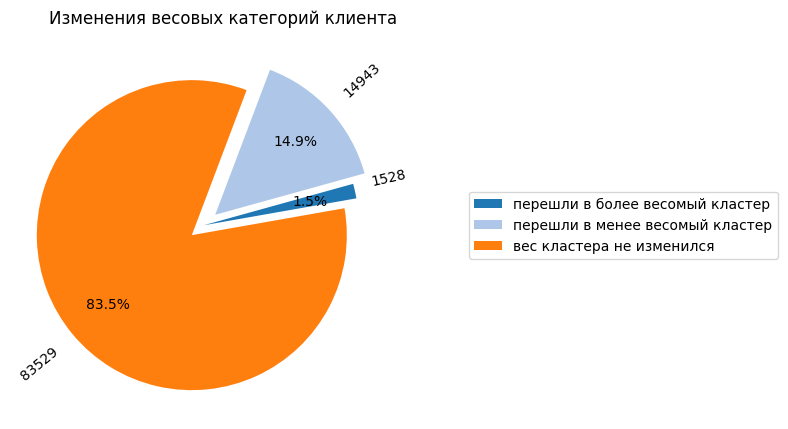

In [197]:
plt.figure(figsize=(5, 10))

plt.pie([i1,i2,i3], autopct='%1.1f%%', startangle=10, pctdistance=0.7, colors=plt.cm.tab20.colors, rotatelabels=True,
        labels=[i1,i2,i3], explode=[0.0, 0.1, 0.1],)
plt.title('Изменения весовых категорий клиента', loc='right')
plt.legend(['перешли в более весомый кластер',
           'перешли в менее весомый кластер',
           'вес кластера не изменился'], loc='right',  bbox_to_anchor=(2, 0.5))

plt.show()

### Посмотрим в каких кластерах не осталось клиентов

In [198]:
start_clasters_counts = test_df['start_cluster_2'].value_counts() # Берем количество вхождений каждого кластера в start_cluster_2
end_clusters_counts = test_df['end_cluster_2'].value_counts() # Берем количество вхождений каждого кластера в end_cluster_2

In [199]:
for i in list(weights_dict.keys()):
    if i not in list(end_clusters_counts.keys()):
        print(i)

{α, π}


- Получилось что в кластере '{α, π}' не осталось клиентов

In [200]:
del weights_dict['{α, π}'] # удалим кластер без клиентов из словаря весов что бы не мешался

In [201]:
difference = pd.DataFrame(end_clusters_counts-start_clasters_counts).T #вычислим разницу между start и end кластерами

In [202]:
difference2 = difference.copy()

In [203]:
difference2 = difference2 * weights_dict # умножим разницу на веса и получим изменение весов для каждого кластера

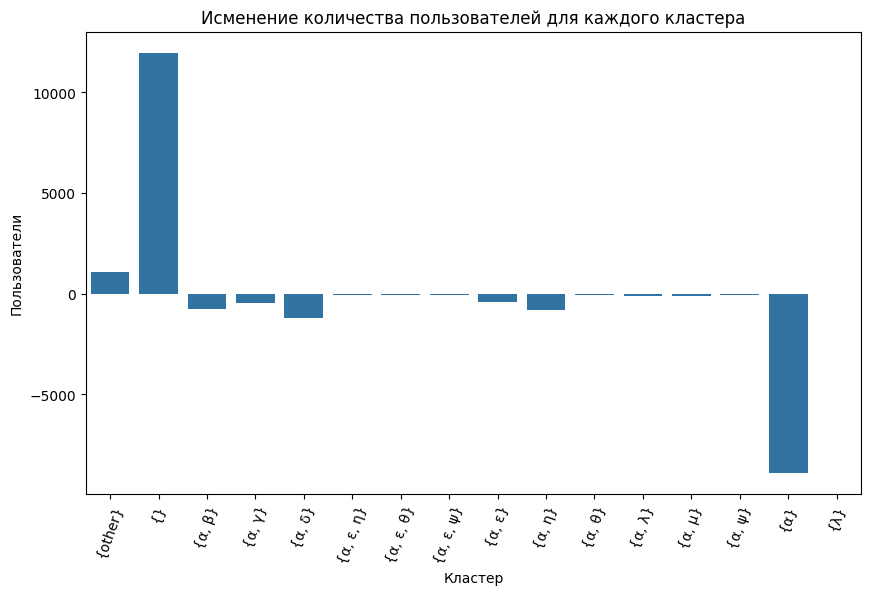

In [214]:
plt.figure(figsize=(10,6))
sns.barplot(x=difference.columns, y=difference.values[0])
plt.title('Исменение количества пользователей для каждого кластера')
plt.ylabel('Пользователи')
plt.xlabel('Кластер')
plt.xticks(rotation=70)

plt.show()

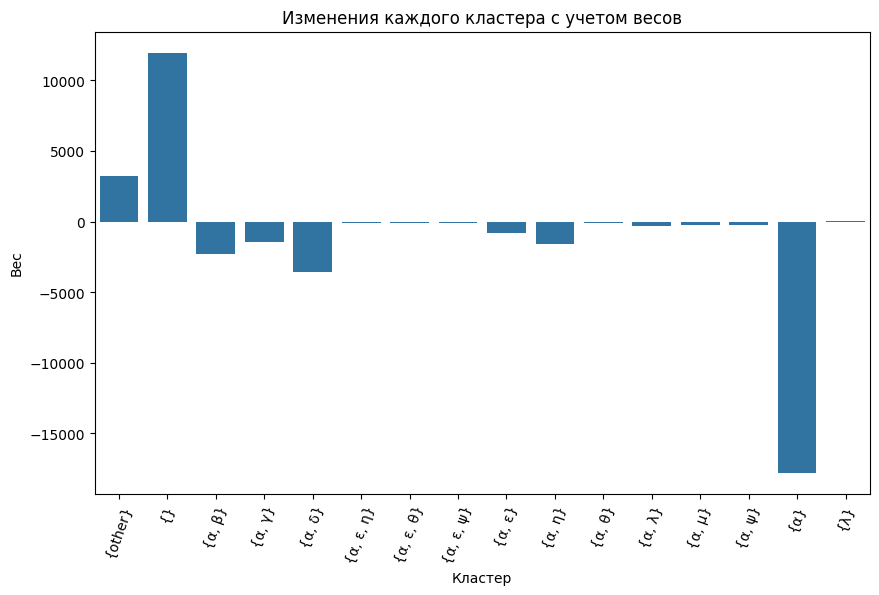

In [215]:
plt.figure(figsize=(10,6))
sns.barplot(x=difference2.columns, y=difference2.values[0])
plt.title('Изменения каждого кластера с учетом весов')
plt.ylabel('Вес')
plt.xlabel('Кластер')
plt.xticks(rotation=70)

plt.show()

## Тепловая карта вероятностей перехода между кластерами

In [206]:
count_clusters = len(weights_dict.keys())  # Возьмем количество элементов в словаре weights_dict
klasters = list(weights_dict.keys()) # Сделаем список из ключей в словаре weights_dict

In [207]:
transition_matrix = np.zeros((count_clusters, count_clusters))            # Создаем матрицу размером 16x16 (ранее мы удалили 1 класс из за отсутствия в нем клиентов)

In [208]:
for i in range(count_clusters):
    for j in range(count_clusters):
        # Подсчитываем количество переходов из кластера i в кластер j
        transition_matrix[i, j] = test_df[(test_df['start_cluster_2'] == klasters[i]) & (test_df['end_cluster_2'] == klasters[j])].shape[0] # заполняем матрицу

In [209]:
transition_df = pd.DataFrame(transition_matrix, index=[f'Кластер {klasters[i]}' for i in range(count_clusters)], 
columns=[f'Кластер {klasters[i]}' for i in range(count_clusters)]) # воздадим df из полученной ранее матрицы

In [210]:
transition_probabilities = transition_matrix / transition_matrix.sum(axis=1)[:, None]

In [211]:
transition_prob_df = pd.DataFrame(transition_probabilities, 
                                  index=[f'{klasters[i]}' for i in range(count_clusters)], 
                                  columns=[f'{klasters[i]}' for i in range(count_clusters)]).round(2)

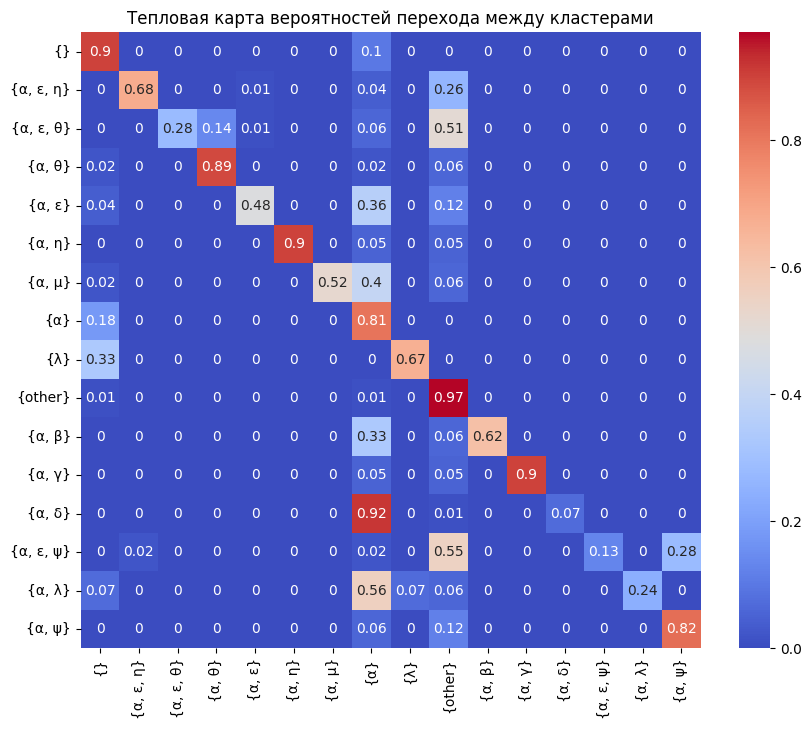

In [212]:
plt.figure(figsize=(10, 8))
sns.heatmap(transition_prob_df, annot=True, cmap='coolwarm')
plt.title('Тепловая карта вероятностей перехода между кластерами')
plt.show()